In [8]:
pip install --upgrade geneticalgorithm

In [9]:
import yfinance as yf
from geneticalgorithm import geneticalgorithm as ga
import numpy as np
import pandas as pd

In [10]:
# Descargamos datos de cierre de las acciones de nuestro portafolio
fecha_inicio = '2018-08-30'
fecha_termino = '2023-08-30'
data = yf.download(['MSFT', 'GOOGL', 'AAPL', 'NVDA', 'JPM', 'PYPL', 'PG', 'KO', 'AMZN', 'WMT', 'IQQH.DE', 'USO'], start=fecha_inicio, end=fecha_termino)['Close']

[*********************100%%**********************]  12 of 12 completed


In [11]:
# Calculamos el rendimeinto compuesto diario de las acciones y definimos el monto a invertir
rendimientos = data.pct_change().dropna()
inversion = 10000000

 The best solution found:
 [0.07473505 0.15680802 0.27257399 0.38343069 0.01340524 0.17431954
 0.24902127 0.90674484 0.15911501 0.31022727 0.02627043 0.01014784]

 Objective function:
 -0.0011813470536617405


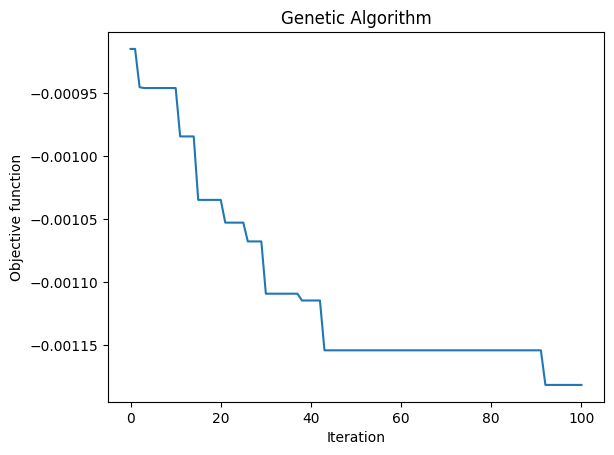

Invertir 273074.6607 pesos en AAPL
Invertir 572961.3776 pesos en AMZN
Invertir 995959.0312 pesos en GOOGL
Invertir 1401018.7386 pesos en IQQH.DE
Invertir 48981.4410 pesos en JPM
Invertir 636946.7552 pesos en KO
Invertir 909899.6889 pesos en MSFT
Invertir 3313158.0947 pesos en NVDA
Invertir 581390.8893 pesos en PG
Invertir 1133540.4884 pesos en PYPL
Invertir 95989.6101 pesos en USO
Invertir 37079.2243 pesos en WMT
Volatilidad del portafolio: 0.0192
Rendimiento del portafolio: 0.0012


In [12]:
# Generamos la función de evaluación (GA)
def funcion_evaluacion(porcentajes):
  pesos = np.array(porcentajes)
  pesos = pesos/pesos.sum() # Garantizamos que la suma de los pesos sumen 100%
  monto_inicial = inversion # Asignamos una inversión de $10,000,000
  resultados = []
  saldo = 0

  # Calculamos el importe y número de títulos
  precios_iniciales = data.iloc[0].values
  importes = [monto_inicial * porcentaje for porcentaje in pesos]
  titulos = [int(importe/precio) for importe, precio in zip(importes, precios_iniciales)]

  # Calculamos el rendimeinto del portafolio de manera diaria en el periodo elegido
  for fecha, fila in data.iterrows():
    precios_acciones = fila.values
    if saldo == 0:  # Calcula el saldo solo para el primer día del análsis
      saldo = sum([importe - titulo * precio for importe, titulo, precio in zip(importes, titulos, precios_acciones)])

    precio_portafolio = sum([titulo * precio for titulo, precio in zip(titulos, precios_acciones)]) + saldo
    resultados.append({'Precios del portafolio': precio_portafolio})

  # Creamos un DataFrame con los resultados
  tabla_resultados = pd.DataFrame(resultados)

  # Calculamos el rendimiento compuesto diario del portafolio y el rendieminto del portafolio
  rendimientos_portafolio = tabla_resultados['Precios del portafolio'].pct_change().dropna()
  rendimiento_portafolio = rendimientos_portafolio.mean()

  # Calculamos la desviación estandar del portafolio
  return -rendimiento_portafolio

# Definimos el dominio de los pesos entre 0 y 1 (0%-100%)
limites = np.array([[0,1]] * len(data.columns))

# Definimos los parámetros del algoritmo genético
parametros_algoritmo = {'max_num_iteration': 100,\
                   'population_size':10,\
                   'mutation_probability':0.5,\
                   'elit_ratio': 0.2,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

# Generamos el Algoritmo Genético
algoritmo = ga(function=funcion_evaluacion, dimension=len(data.columns), variable_type='real', variable_boundaries=limites, algorithm_parameters=parametros_algoritmo)
algoritmo.run()

# Obtenemos los pesos optimos del portafolio (GA) y calculamos el rendimiento y desviación estandar del portafolio
pesos_optimos = algoritmo.output_dict['variable']
pesos_optimos = pesos_optimos/pesos_optimos.sum()

monto_inicial=inversion
resultados = []
saldo = 0
precios_iniciales = data.iloc[0].values
importes = [monto_inicial * porcentaje for porcentaje in pesos_optimos]
titulos = [int(importe/precio) for importe, precio in zip(importes, precios_iniciales)]

for fecha, fila in data.iterrows():
  precios_acciones = fila.values
  if saldo == 0:  # Calcula el saldo solo para el primer día del análsis
    saldo = sum([importe - titulo * precio for importe, titulo, precio in zip(importes, titulos, precios_acciones)])

  precio_portafolio = sum([titulo * precio for titulo, precio in zip(titulos, precios_acciones)]) + saldo
  resultados.append({'Precios del portafolio': precio_portafolio})

tabla_resultados = pd.DataFrame(resultados)

rendimientos_portafolio = tabla_resultados['Precios del portafolio'].pct_change().dropna()
rendimiento_portafolio = rendimientos_portafolio.mean()

# Calculamos el dinero a invertir en cada acción
inversion_por_accion = pesos_optimos * inversion

# Imprimimos los resultados
for accion, dinero in zip(data.columns, inversion_por_accion):
    print(f"Invertir {dinero:.4f} pesos en {accion}")
desv_est_portafolio = np.sqrt(np.matmul(pesos_optimos, np.matmul(rendimientos.cov(),pesos_optimos.T)))
print(f"Volatilidad del portafolio: {desv_est_portafolio:.4f}")
print(f"Rendimiento del portafolio: {rendimiento_portafolio:.4f}")

In [13]:
print(pesos_optimos.sum())
print(pesos_optimos)
pesos_optimos= pd.DataFrame(pesos_optimos)
pesos_optimos.to_excel('Pesos.xlsx')
print(rendimientos_portafolio)
print(rendimiento_portafolio)
print(saldo)

1.0
[0.02730747 0.05729614 0.0995959  0.14010187 0.00489814 0.06369468
 0.09098997 0.33131581 0.05813909 0.11335405 0.00959896 0.00370792]
1       0.002389
2       0.000000
3       0.002971
4      -0.016947
5      -0.009431
          ...   
1286    0.026146
1287   -0.004615
1288   -0.013681
1289    0.013275
1290    0.032071
Name: Precios del portafolio, Length: 1290, dtype: float64
0.0011813470536617405
485.037820814352


In [16]:
cov = rendimientos.cov()
cov.to_excel('cov.xlsx')